# Before you start

## Defining cell type by their molecular features
In the previous tutorial we have compared and contrast **electrophysiology features**, and **structure** of different cell types in the brain. **Gene expression patterns** are also commonly used to define neuronal cell types. Since at any moment each cell makes mRNA from only a fraction of the genes it carries, by measuring the cell's RNA transcripts we can get a sense of the cell's gene expression patterns. The sum of a cell's RNA transcripts is called its **transcriptome**, and single-cell RNA sequencing (**scRNA-seq**) is one commonly used transcriptomic technology.

<details>
<summary> <font color='blue'>Click here for a list of scRNA-seq data published by the Allen Institute for Brain Science</font></summary>

- Adult mouse cortical cell taxonomy revealed by single cell transcriptomics (Tasic et al. 2016)

- Shared and distinct transcriptomic cell types across neocortical areas (Tasic et al. 2018)

- A taxonomy of transcriptomic cell types across the isocortex and hippocampal formation (Yao et al. 2021)
</details>


Sequencing data from scRN-seq experiments are usually contained in a matrix of expression values. This matrix is known as a **count matrix**, which contains the number of reads mapped to each gene (row) in each cell (column).
<details>
<summary> <font color='blue'>What is a 'read'?</font></summary>
In a typical scRNA-Seq experiment, the mRNA molecules are first reverse transcribed into cDNA molecules, which are then amplified and converted into libraries of cDNA fragments. These cDNA libraries are then sequenced, and each sequenced fragment (or read) corresponds to a portion of a cDNA molecule. We can use computer algorithms to align these reads to a reference genome or transcriptome and determine the gene(s) from which each read originates. By counting the number of reads that map to each gene, we can estimate the expression level of individual genes in individual cells.
</details>

## Patch-seq
Patch-seq is an experimental technique that combined scRNA-seq with intracellular electrophysiology, which enables one to directly relate the transcriptomic features of a given neuron to other identifying characteristics of the same neuron.


<img src="https://drive.google.com/uc?export=view&id=1-43JtuZQ99SEyJ1yiYcm3fa5MSmLP8z5"></img>


## Objectives
- Obtaining normalized count matrix from raw read counts
- Exploring [Patch-deq dataset](https://linkinghub.elsevier.com/retrieve/pii/S009286742031254X) generated from mouse primary visual cortex.
- Correlating gene expression with intracellular electrophsiological features.

# Tutorial steps
1. [Setting up our coding environment](#setup)
2. [Obtaining count matrix for the Patch-seq dataset](#patch_seq)
3. [Normalizing count matrix](#normalize)
4. [Plotting expression levels of ion channel genes](#plot_one_gene)
5. [Assigning subclass labels](#labels)
6. [Plotting electrophysiological features across subclass](#ephys_subclass)
7. [Correlating an electrophysiological feature with the expression of a gene](#gene_ephys_corr)
8. [Constructing Gene-ephys Correlation Matrix](#corr_matrix)

<a name="setup"></a>
# Step 1. Setting up our coding environment


## Installing UMAP

In [1]:
!pip install -q umap-learn

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import tarfile
import io
import json
import gc
import umap
import scipy.sparse as sparse

/Users/xunuo/miniconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/xunuo/miniconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/xunuo/miniconda3/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecatio

<a name="patch_seq"></a>
# Step 2. Obtaining count matrix for the Patch-seq dataset

## Download count matrix for the Patch-seq dataset from NeMO




Run the code cell below to download the count matrix from [The Neuroscience Multi-omic Archive (NeMO)](https://nemoarchive.org/). This step should take around 1 minute.

In [2]:
url = \
"https://data.nemoarchive.org/other/AIBS/AIBS_patchseq/transcriptome/scell/SMARTseq/processed/analysis/20200611/20200513_Mouse_PatchSeq_Release_count.v2.csv.tar"
response = urllib.request.urlopen(url)
tar_file = io.BytesIO(response.read())

Since the count matrix was deposited on NeMO as a tar file, we need to extract the csv file from the tar file using the `tarfile` package available as a part of the Python Standard Library, and then read the csv file into a Pandas DataFrame object.

**Note**: The cell below can only be run once. It will throw an error if you try to run it again! If you need to run it again for some reason, please restart the kernel.

In [3]:
with tarfile.open(fileobj=tar_file) as tar:
    count_matrix = pd.read_csv(io.StringIO(tar.extractfile(tar.getmembers()[0]).read().decode('utf-8')))
del tar_file
gc.collect()
print('count_matrix CSV file extracted.')

count_matrix CSV file extracted.


Below, we'll do some cleaning up of the `count_matrix`, and then show it.

In [4]:
# Set the index to be the cell ID, and rename it
count_matrix.set_index("Unnamed: 0", inplace = True)
count_matrix.index.rename('gene_name',inplace = True)

# remove genes that are not expressed in any cells
count_matrix = count_matrix.iloc[np.flatnonzero(count_matrix.sum(axis = 1) != 0), :]

print(f"There are {count_matrix.shape[1]} cells and {count_matrix.shape[0]} genes in the count matrix:")

# Show the first 5 rows of the count matrix
count_matrix.head()

There are 4435 cells and 41930 genes in the count matrix:


,PS0810_E1-50_S88,PS0817_E1-50_S19,PS0817_E1-50_S25,PS0817_E1-50_S26,PS0817_E1-50_S27,PS0817_E1-50_S28,PS0817_E1-50_S46,PS0817_E1-50_S52,PS0830_E1-50_S17,PS0830_E1-50_S19,...,SM-J39ZH_S561_E1-50,SM-J39ZH_S562_E1-50,SM-J39ZH_S565_E1-50,SM-J39ZH_S566_E1-50,SM-J39ZH_S571_E1-50,SM-J39ZH_S576_E1-50,SM-J3A1L_S592_E1-50,SM-J3A1L_S593_E1-50,SM-J3A1L_S603_E1-50,SM-J3A1L_S604_E1-50
gene_name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007P14Rik,0,0,0,81,51,35,0,0,483,89,...,0,0,14,0,14,0,20,38,4,56
0610009B22Rik,0,0,41,0,0,0,0,25,0,64,...,21,0,12,13,23,38,0,0,0,54
0610009E02Rik,0,0,0,0,0,1,11,0,0,0,...,0,0,9,0,1,0,0,13,0,50


In this count matrix, each row represents one gene and the row names are the gene names, e.g., **0610005C13Rik**.

<details>
<summary> <font color='blue'>Click here for explanation why this gene has a name that does not seem to make any sense </font></summary>
You might wonder why this gene has a name that does not seem to make any sense. This is because 0610005C13Rik is an example of a placeholder name that is often given to genes when they are first discovered. This type of name is typically used when the function of the gene is not yet known. Once the function of a gene is better understood, it may be given a more descriptive name that reflects its function.
</details>



On the other hand, each column in the count matrix represents one cell and the column names are `transcriptomic_sample_id`, e.g., `PS0810_E1-50_S88`, which uniquely identify the transcriptomic data collected from each cell.

<a name="normalize"></a>
# Step 3. Normalizing gene counts CPM

The `count_matrix` DataFrame contains raw read counts. The figure below is a histogram of the sum of raw read counts detected in individual cells. As we can see, the distribution is uneven, which is largely due to the variability inherent in the experimental technologies used to obtain the read counts, rather than biological variability. Thus, to compare gene expression levels between cells, we need to normalize the raw read counts for differences in total number of reads per cells.

Text(0, 0.5, 'Number of cells')

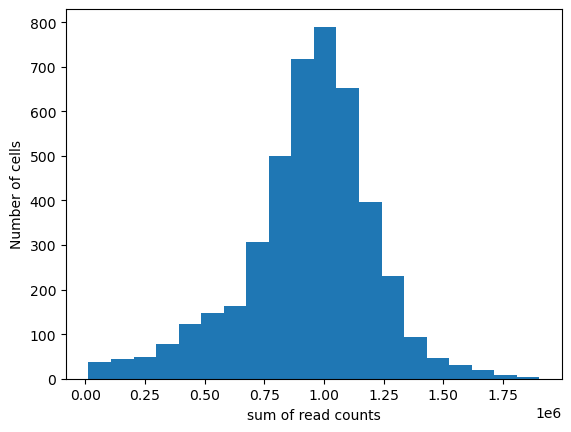

In [5]:
plt.hist(count_matrix.sum(axis = 0), bins = 20)
plt.xlabel("sum of read counts")
plt.ylabel("Number of cells")

One common way to normalize read counts is to calculate counts per million (CPM), which is obtained by dividing read counts for genes by the sum of raw read counts in that cell, also known as **library size**, and multiplying the results by a million, respectively.

In [6]:
# Import precomputed library sizes for each cell, each row contains the library size for one cell
original_lib_size = pd.read_csv(urllib.request.urlopen("https://raw.githubusercontent.com/nuoxuxu/gene-ephys-tutorial/main/data/lib_size.csv"), sep = "\t", index_col = 0)

# Remove cells that contain NA values
lib_size = original_lib_size.dropna().loc[original_lib_size.library_size != 0]

# Remove the cells that have been removed in the previous step from lib_size
count_matrix = count_matrix.loc[:, count_matrix.columns.isin(lib_size.index)]

print(f"{len(original_lib_size) - len(lib_size)} cells were dropped.")

# Plot a heatmap, similar to the website!
# count_matrix.style.background_gradient(cmap ='RdBu_r')

81 cells were dropped.


><b>Task:</b> Calculating counts per million for `count_matrix`, using precomputed library sizes provided in `lib_size`
>- Note that `lib_size` is a DataFrame where the index stores the `transcriptomic_sample_id`, and the library size of the corresponding cell is stored in the `library_size` column
>- To convert raw read counts for all genes expressed in a cell, we need to divide the raw read counts for each gene by the library size of the cell (which is the total number of reads) and then multiply this number by a factor of 100000.
>- Below is an example of how to calculate counts per million for one cell. Your task is to calculate CPM for all cells in `count_matrix`

For the cell whose `transcriptomic_sample_id` is `PS0817_E1-50_S19`, we can extract its `library_size` using the following code:

In [7]:
example_lib_size = lib_size.loc['PS0817_E1-50_S19', 'library_size']
print(f"The library size for cell PS0817_E1-50_S19 is {example_lib_size}.")

The library size for cell PS0817_E1-50_S19 is 692522.0.


The raw read counts of all genes expressed in a cell whose `transcriptomic_sample_id` is `PS0817_E1-50_S19` would be

In [8]:
count_matrix["PS0817_E1-50_S19"]

gene_name
0610005C13Rik     0
0610006L08Rik     0
0610007P14Rik     0
0610009B22Rik     0
0610009E02Rik     0
                 ..
Zzef1             0
Zzz3             60
a                 0
l7Rn6             2
n-R5s136          0
Name: PS0817_E1-50_S19, Length: 41930, dtype: int64

To calculate the CPM of a gene in a cell, we need to divide the raw read count of all genes expressed in this cell by the library size of this cell, and then multiply the result by a factor of 1000000


In [9]:
count_matrix['PS0817_E1-50_S19'] / lib_size.loc['PS0817_E1-50_S19', 'library_size'] * 10000

gene_name
0610005C13Rik    0.000000
0610006L08Rik    0.000000
0610007P14Rik    0.000000
0610009B22Rik    0.000000
0610009E02Rik    0.000000
                   ...   
Zzef1            0.000000
Zzz3             0.866398
a                0.000000
l7Rn6            0.028880
n-R5s136         0.000000
Name: PS0817_E1-50_S19, Length: 41930, dtype: float64

Using a for loop, can you compute the CPM for all cells and assign the result to the corresponding entry in the count_matrix?

**Hint 1**: `count_matrix.columns` returns a list of all `ranscriptomic_sample_id`, you can iterate over this list to compute the CPM for each cell

**Hint 2**: using the example for one cell above as a reference.

In [11]:
# First, we need to create an empty list to store the CPM for each cell

# cpm = []

# Then, for each cell, we compute the CPM and append it to the list

# for column in count_matrix.columns:
#     cpm.append(...)

# Finally, we concatenate the list of CPM into a dataframe (Hint: use pd.concat)

# cpm = ...

In [10]:
# First, we need to create an empty list to store the CPM for each cell
cpm = []

# Then, for each cell, we compute the CPM and append it to the list
for column in count_matrix.columns:
    cpm.append(count_matrix[column] / lib_size.loc[column, 'library_size'] * 10000)

# Finally, we concatenate the list of CPM into a dataframe
cpm = pd.concat(cpm, axis = 1)

In [ ]:
# delete count_matrix since we don't need it anymore
del count_matrix
gc.collect()

[*Click here fore solution*](https://github.com/nuoxuxu/gene-ephys-tutorial/blob/main/solutions/CodingFocused_exercise_1.py)

Inspect the normalized count matrix `cpm`

In [13]:
cpm.head()

,PS0810_E1-50_S88,PS0817_E1-50_S19,PS0817_E1-50_S25,PS0817_E1-50_S26,PS0817_E1-50_S27,PS0817_E1-50_S28,PS0817_E1-50_S46,PS0817_E1-50_S52,PS0830_E1-50_S17,PS0830_E1-50_S19,...,SM-J39ZH_S561_E1-50,SM-J39ZH_S562_E1-50,SM-J39ZH_S565_E1-50,SM-J39ZH_S566_E1-50,SM-J39ZH_S571_E1-50,SM-J39ZH_S576_E1-50,SM-J3A1L_S592_E1-50,SM-J3A1L_S593_E1-50,SM-J3A1L_S603_E1-50,SM-J3A1L_S604_E1-50
gene_name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610006L08Rik,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610007P14Rik,0.0,0.0,0.000000,0.577373,0.668481,0.237350,0.000000,0.000000,2.10004,0.394140,...,0.000000,0.0,0.095540,0.000000,0.083297,0.000000,0.177617,0.324842,0.300616,0.341606
0610009B22Rik,0.0,0.0,0.264964,0.000000,0.000000,0.000000,0.000000,0.223907,0.00000,0.283427,...,0.176601,0.0,0.081892,0.087101,0.136846,0.216234,0.000000,0.000000,0.000000,0.329406
0610009E02Rik,0.0,0.0,0.000000,0.000000,0.000000,0.006781,0.135828,0.000000,0.00000,0.000000,...,0.000000,0.0,0.061419,0.000000,0.005950,0.000000,0.000000,0.111130,0.000000,0.305005


Transpose `cpm` so that each row is one cell and each column is one gene.

In [14]:
cpm = cpm.T

The normalized read counts are often log-transformed for visualization purposes

In [15]:
cpm = np.log2(cpm + 1)

<a name="plot_one_gene"></a>
# Step 4. Plotting expression levels of ion channel genes

Now that we have normalized and log-transformed the raw read counts, we can present the expression levels of selected genes in all cells as a boxplot. The code below creates a boxplot of expression levels of Kv3 voltage-gated potassium channels (Kcnc1, Kcnc2, Kcnc3 and Kcnc4). These channels are known to contribute to neurons' ability to generate high-frequency activity.

In [16]:
# You can put any genes in this list
gene_list = ["Kcnc1", "Kcnc2", "Kcnc3", "Kcnc4"]

Text(0, 0.5, 'log(CPM + 1)')

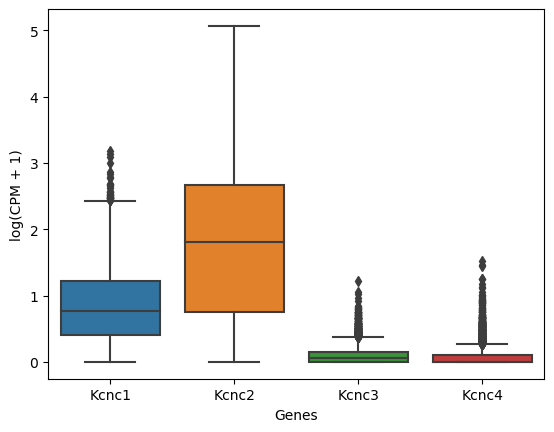

In [17]:
sns.boxplot(cpm[gene_list])
plt.xlabel('Genes')
plt.ylabel('log(CPM + 1)')

However, plotting the expression levels of genes across all cells in the dataset like this is not very helpful. What we want to know is whether the expression level of a gene is different between different neuronal subclasses. Since this dataset contains subclass label for each neuron, we can try to address this question by plotting gene expression across different subclasses.

<a name="labels"></a>
# Step 5. Assigning subclass labels

## Obtaining subclass labels

Since each neuron has already been assigned a subclass label in the paper, our task is to obtain subclass labels (as defined in the original paper) for each cell in `cpm`.

<details>
<summary> <font color='blue'>Click here for explanation how this was done </font></summary>
First, we need to convert the `transcriptomics_sample_id` for each column in `cpm` to `cell_specimen_id`. This is because the mapping from each cell to the cell type it is assigned to is stored in a csv file where each row (represents one cell) is identified by  `cell_specimen_id` only.
This step is also necessary for correlating transcriptomic signatures with electrophysiological data, because electrophysiological data are provided in another csv file where `cell_specimen_id` is the only identifier for each cell. After this conversion step we can merge transcriptomic and electrophysiological data based on this shared label:  `cell_specimen_id`.
</details>




In [18]:
# @markdown Execute this block of code to assign cell subclass labels to all cells

# From the patchseq_metadata file downloaded from the Allen Institute website, we can obtain a mapping from transcriptomics_sample_id to cell_specimen_id
url = "https://raw.githubusercontent.com/nuoxuxu/gene-ephys-tutorial/main/data/20200625_patchseq_metadata_mouse.csv"
metadata = pd.read_csv(urllib.request.urlopen(url), usecols = ["cell_specimen_id",  "transcriptomics_sample_id"])\
    .set_index("transcriptomics_sample_id")\
    .to_dict()["cell_specimen_id"]

# From the SpecimenMetadata file downloaded from the Allen Institute website, we can obtain a mapping from cell_specimen_id to subclass
url = "https://raw.githubusercontent.com/nuoxuxu/gene-ephys-tutorial/main/data/SpecimenMetadata.csv"
ID_to_subclass = pd.read_csv(urllib.request.urlopen(url), usecols=["Specimen ID", "T type sub-class"], index_col=0) \
    ['T type sub-class'].str.replace(' interneuron', '') \
    .to_dict()

In [19]:
# Convert column names from transcriptomics_sample_id to subclass labels
cpm = cpm.assign(subclass = cpm.index.map(metadata).map(ID_to_subclass))

# Subset for cells that belong to the 5 most abundant subclasses
cpm = cpm.loc[cpm.subclass.isin(["Pvalb", "Sst", "Sncg", "Lamp5", "Vip"])]

# Show the first 5 rows of the dataframe
cpm.head()

gene_name,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,n-R5s136,subclass
PS0810_E1-50_S88,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.082417,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.016864,0.000000,0.000000,0.000000,0.0,Vip
PS0817_E1-50_S19,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.900257,0.000000,0.041075,0.0,Sst
PS0817_E1-50_S25,0.0,0.0,0.000000,0.339097,0.0,0.0,0.0,0.0,0.009293,0.000000,...,0.000000,0.000000,1.287559,0.232033,0.000000,0.000000,0.000000,0.000000,0.0,Sst
PS0817_E1-50_S26,0.0,0.0,0.657524,0.000000,0.0,0.0,0.0,0.0,0.000000,0.108904,...,0.337698,0.010247,0.296426,0.563236,0.020422,0.477204,0.010247,0.345812,0.0,Sst
PS0817_E1-50_S27,0.0,0.0,0.738535,0.000000,0.0,0.0,0.0,0.0,0.143863,0.109220,...,0.194317,0.000000,0.997233,0.365541,0.478427,0.000000,0.000000,0.194317,0.0,Sst


## Expression of *Kcnc2* across subclasses

After assigning subclass label to each cell, we can plot the expression levels of genes across subclasses. Since *Kcnc2* is the most abundant gene in this dataset, we will plot the expression level of Kcnc2 across neuronal subclasses.

<Axes: xlabel='subclass', ylabel='Kcnc2'>

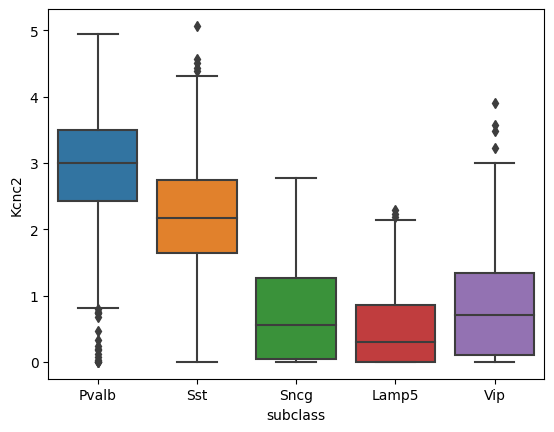

In [21]:
sns.boxplot(cpm[["subclass", "Kcnc2"]], x = "subclass", y = "Kcnc2",
            order = ["Pvalb", "Sst", "Sncg", "Lamp5", "Vip"])

This plot shows that *Kcnc2* expression is higher in the *Pvalb* interneurons, which are known to encompass fast-spiking interneurons.

## UMAP visualization

Uniform manifold approximation and projection (UMAP) is a dimensionality reduction algorithm commonly used to visualize  high-dimensional data on a two-dimensional space. Here, we can see that the cells that belong to the same subclass are close to each other in the 2D UMAP space.

In [20]:
reducer = umap.UMAP()

Because running UMAP consumes memory, and we have limited memory on the Colab server, we need to convert `cpm` DataFrame to a sparse matrix to save memory

In [23]:
# get the subclass and gene labels and sparse matrices from `cpm`
subclass_labels = cpm["subclass"]
gene_names = cpm.columns.values
sparse_cpm = sparse.csr_matrix(cpm.drop(columns = "subclass"))

In [29]:
embedding = reducer.fit_transform(sparse_cpm)

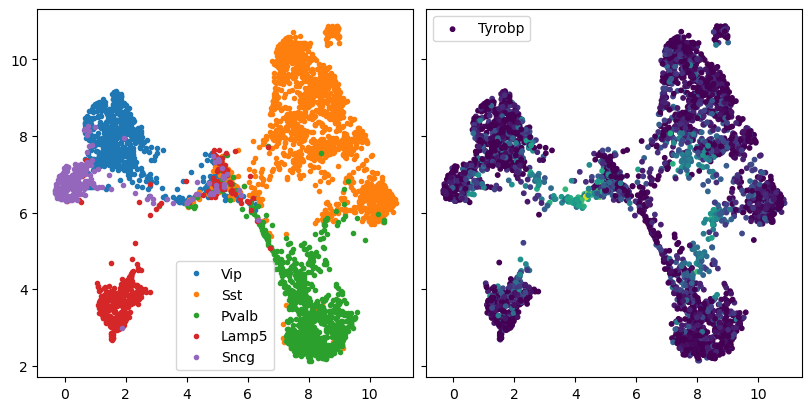

In [51]:
fig, axs = plt.subplots(1, 2, layout="constrained", figsize = (8, 4), sharey = True)
for i, subclass in enumerate(subclass_labels.unique()):
    axs[0].plot(
        embedding[np.flatnonzero(subclass_labels == subclass), 0],
        embedding[np.flatnonzero(subclass_labels == subclass), 1],
        'o', markersize = 3,
        label = subclass)
axs[0].legend()
axs[1].scatter(embedding[:, 0], embedding[:, 1], s = 10, c = sparse_cpm[:, np.where(gene_names == "Tyrobp")[0][0]].toarray(), label = "Tyrobp")
axs[1].legend()

<a name="ephys_subclass"></a>
# Step 6. Plotting electrophysiological features across subclass

## Importing extracted electrophysiological features

How do we know that *Pvalb* neurons are fast-spiking? We can import electrophysiological data from the `SpecimenMetadata` file

In [152]:
# You can import any ephys features that are contained in SpecimenMetadata

column_list = ['Specimen ID', 'Avg ISI', 'Fast trough V (long square) (millivolts)', 'Trough V (long square) (millivolts)', 'Peak V (long square) (millivolts)', 'Peak V (short square) (millivolts)',\
                   'Upstroke/downstroke ratio (long square)', 'Threshold V (long square) (millivolts)', 'F I curve slope', 'sag', 'tau', 'Vrest (millivolts)']

# import the ephys features from SpecimenMetadata, only using the columns in column_list

ephys_data = pd.read_csv(
    urllib.request.urlopen("https://raw.githubusercontent.com/nuoxuxu/gene-ephys-tutorial/main/data/SpecimenMetadata.csv"),
    usecols=column_list, index_col=0)

# Assigning the subclass label to each cell

ephys_data["subclass"] = ephys_data.index.map(ID_to_subclass)

# Subset for cells that belong to the 5 most abundant subclasses

ephys_data = ephys_data.loc[ephys_data["subclass"].isin(["Pvalb", "Sst", "Sncg", "Lamp5", "Vip"])]

In [103]:
ephys_data.head()

,Avg ISI,Fast trough V (long square) (millivolts),F I curve slope,Peak V (long square) (millivolts),Peak V (short square) (millivolts),sag,tau,Threshold V (long square) (millivolts),Trough V (long square) (millivolts),Upstroke/downstroke ratio (long square),Vrest (millivolts),subclass
Specimen ID,,,,,,,,,,,,
888317699,77.337143,-49.899998,0.219149,33.968750,34.806252,0.088104,15.476233,-30.881252,-50.025002,1.593478,-68.242925,Sst
765853817,22.306667,-48.737499,0.700000,14.006250,14.231251,0.053379,41.795072,-28.781252,-48.806252,1.496194,-70.211269,Pvalb
671876425,87.811111,-52.343754,0.128299,15.562501,15.081251,0.010278,7.969012,-39.093750,-56.500004,3.799292,-82.387016,Lamp5
906699622,44.145000,-52.568752,0.075000,28.318752,28.806252,0.020501,22.566332,-32.887505,-52.618748,1.849121,-69.601582,Sst
778301240,9.276981,-49.618752,1.802804,27.556252,30.518749,0.086389,12.057492,-29.000002,-49.799999,1.530240,-49.922277,Pvalb


## Plotting electrophysiological features across subclass

We can plot the values of any electrophysiological properties across the five subclass. *F I curve* is the slope of the curve between firing rate (f) and current injected. It is commonly used for distinguishing fast spiking interneurons. The figure shows that *Pvalb* neurons have higher *F I slope* than the rest.

<Axes: xlabel='subclass', ylabel='F I curve slope'>

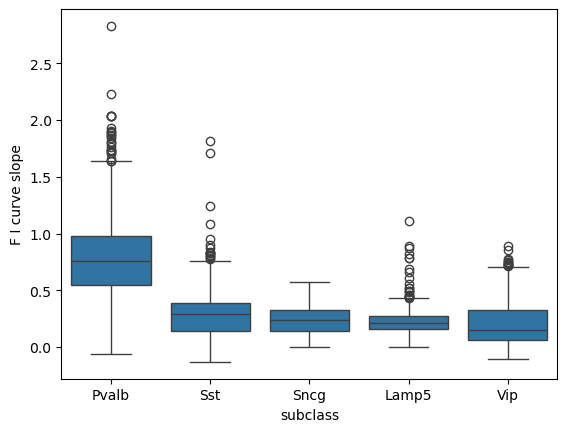

In [191]:
sns.boxplot(ephys_data, x="subclass", y="F I curve slope", order=["Pvalb", "Sst", "Sncg", "Lamp5", "Vip"])

<a name="gene_ephys_corr"></a>
# Step 7. Correlating an electrophysiological feature with the expression of a gene

We have shown that *Kcnc2* is more abundant in Pvalb neurons and that Pvalb neurons have higher values of F I curve slope than other neuronal subclasses. 
looked at how gene expression levels and electrophysiological features could vary across neuronal subclasses, respectively. These two observations suggest that expression level of *Kcnc2* could be directly correlated with F I curve slope.

The unique advantage of Patch-seq is that we have both transcriptomic and electrophysiological data for the same cells, which allows us to directly correlate the two. 


## Plotting gene expression against electrophysiological feature
Here we are plotting the expression level of *Kcnc2* against F I curve slope, colored by subclass. You can substitute the electrophysiological features and genes with any entries in `cpm` and `ephys_data`.

In [182]:
F_I_slope = ephys_data[["F I curve slope", "subclass"]]

In [174]:
Kcnc2 = cpm["Kcnc2"]
Kcnc2.index = Kcnc2.index.map(metadata)

In [183]:
df = pd.merge(Kcnc2, F_I_slope, how = "inner", left_index = True, right_index = True)

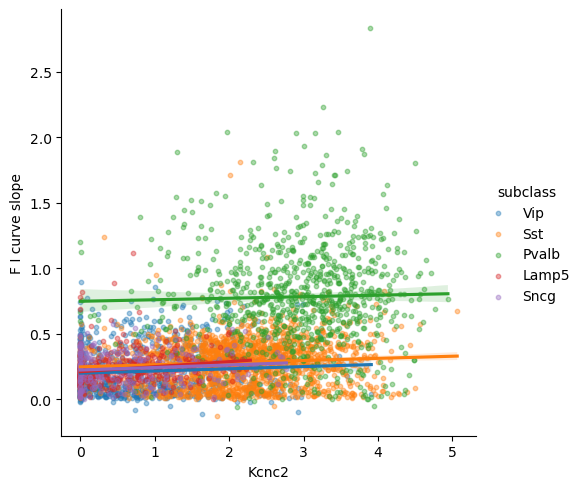

In [188]:
sns.lmplot(df, x = "Kcnc2", y = "F I curve slope", hue = "subclass", scatter_kws = {"s":10, "alpha":0.4})

Because of technical variability in scRNA-seq data, we need to pool raw read counts from cells that belong to the same transcriptomic type (one neuronal subclass contains multiple transcriptomic types), and then normalize and transform the pooled read counts. As a result of this operation, we will have one expression value for each gene for one transcriptomic type. Then we will correlated this "pooled" expression value with the median electrophysiological values of cells within the corresponding transcriptomic type.

In [110]:
# Obtain mapping from transcriptomic_specimen_ID to T type
ID_to_ttype = pd.read_csv(urllib.request.urlopen(url), usecols=["Specimen ID", "T type"], index_col=0)\
    ['T type']\
    .to_dict()

In [115]:
# Get median F I curve slop values for each T type
median_F_I_slope = ephys_data.assign(ttype = ephys_data.index.map(ID_to_ttype)).groupby("ttype")["F I curve slope"].median()

In [119]:
# Get median expression values of Kcnc2 for each T type
median_Kcnc2 = cpm.assign(ttype = cpm.index.map(metadata).map(ID_to_ttype)).groupby("ttype")["Kcnc2"].median()

In [130]:
# Concatenate `median_F_I_slope` and `median_Kcnc2` into a Pandas DataFrame for plotting in Seaborn
Kcnc2_F_I_slope = pd.concat([median_Kcnc2, median_F_I_slope], axis = 1)

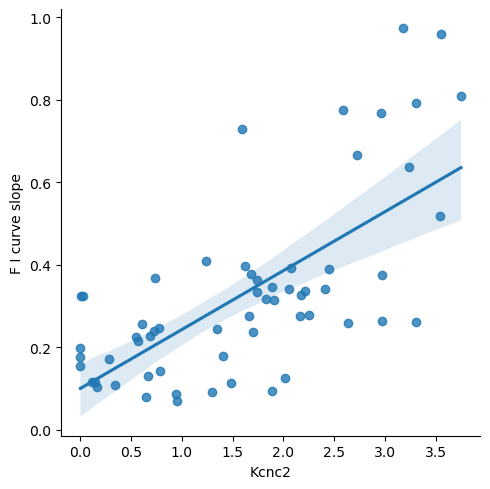

In [131]:
sns.lmplot(Kcnc2_F_I_slope, x = "Kcnc2", y = "F I curve slope")

This plot shows that there is a positive correlation between T type-specific expression of *Kcnc2* and *F I curve slope*.

<a name="corr_matrix"></a>
# Step 8. Constructing Gene-ephys Correlation Matrix

In the *Kcnc2* example we looked at how the expression of one gene could be correlated to one elextrophysiological feature. We can compute correlations between all ion channel genes and all electrophysiological features in the dataset.

## Subsetting for genes that code for voltage-gated ion channels
Below, the `IC_list` file contains a dictionary of genes that encode for ion channels.

In [207]:
# Download the list of voltage-gated ion channel genes (VGICs)

IC_list = json.load(urllib.request.urlopen("https://raw.githubusercontent.com/nuoxuxu/gene-ephys-tutorial/main/data/IC_list.json"))

# remove genes that are not in `cpm`
IC_list['VGIC'].remove("Trpc2")
IC_list['VGIC'].remove("Scn2a")

To construct a matrix where each entry is the Pearson's correlation coefficient between one electrophysiological property and expression level of one gene, we need to make sure that exactly the same cells are present in both DataFrames and that they are in the same order.

In [216]:
cpm_ttype = cpm.assign(ttype = cpm.index.map(metadata).map(ID_to_ttype)).drop(columns = "subclass").groupby("ttype").median()[IC_list['VGIC']]

In [221]:
ephys_data_ttype = ephys_data.assign(ttype = ephys_data.index.map(ID_to_ttype)).drop(columns = "subclass").groupby("ttype").median()

Calculating the correlation matrix between the expression of ion channel genes and electrophysiology features


In [222]:
corr_matrix = np.corrcoef(
    np.hstack([cpm_ttype.to_numpy(), ephys_data_ttype.to_numpy()]), rowvar=False)\
        [:cpm_ttype.shape[1], -ephys_data_ttype.shape[1]:]

/home/s/shreejoy/nxu/miniforge3/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/s/shreejoy/nxu/miniforge3/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Plotting the correlation matrix

In [223]:
fig, ax = plt.subplots(figsize = (10, 22))
sns.heatmap(
    corr_matrix, cmap = "RdBu_r", center = 0,
    xticklabels = ephys_data.columns,
    yticklabels = cpm.columns
    )

# rotate the xticklabels by 90 degrees
plt.xticks(rotation=45, ha='right')

plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fab12048940> (for post_execute):


KeyboardInterrupt: 